In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Fact Table
ord=pd.read_csv('ORDERS.csv')

ord.order_purchase_timestamp = pd.to_datetime(ord.order_purchase_timestamp,format="%m/%d/%Y %H:%M")
# Dimension Table
ord_paym=pd.read_csv('ORDER_PAYMENTS.csv')
ord_rev=pd.read_csv('ORDER_REVIEW_RATINGS.csv')
ord_itms=pd.read_csv('ORDER_ITEMS.csv')
cust=pd.read_csv('CUSTOMERS.csv')

# Sub-Dimension Table-with ord_items
prod=pd.read_csv('PRODUCTS.csv')
sellers=pd.read_csv('SELLERS.csv')

# This one is a sub-dim of both ord_items and customers
geo_loc=pd.read_csv('GEO_LOCATION.csv')


In [7]:
any(ord.order_id.value_counts()>1),any(ord_itms.order_id.value_counts()>1),any(ord_paym.order_id.value_counts()>1)

'''It means there are repeated/duplicate order_ids in ord_itms and ord_paym tables in their order_id column (foreign key).
   
   Indicating that there could be multiple products/items purchased per order and
     multiple payment type used by customer per order.

  So it is safe to comment on the level of info that these three tables are containing:
     - order table is on order level
     - order_items table is on product/item level
     - order_payment table is on payment type (methods used for order's payment) level    
 '''

(False, True, True)

## Observations on the given tables

1. The order_id is pk in orders table.
2. The order_id is foreign key in order_payment and order_items. This is one posssible reason for the order_id to repeat in these tables.
3. The reason for duplicacy in order_id of "order_payment" is that there are payments done by the customers by using multiple payment methods.
4. The reason for duplicacy in order_id of "Order_items" is some of the orders placed where multiple items were sold.


In [292]:
ord.duplicated().any(),ord_itms.duplicated().any(),ord_paym.duplicated().any(),ord_rev.duplicated().any(), \
cust.duplicated().any(),prod.duplicated().any(),sellers.duplicated().any(),geo_loc.duplicated().any()

'''No duplicate rows in each tables'''

(False, False, False, False, False, False, False, False)

In [293]:
ord.shape,ord_itms.shape,ord_paym.shape,ord_rev.shape,prod.shape,sellers.shape

((99441, 8), (112650, 7), (103886, 5), (100000, 5), (32951, 9), (3095, 4))

In [12]:
'''Merging the tables as we may need these in answering some questions.'''

# Merging orders with order_payments table
o_op=pd.merge(ord,ord_paym,left_on='order_id',right_on='order_id',how='inner')
print("Orders and orders_payment:",o_op.shape)

# Merging orders with order_items table
o_oi=pd.merge(ord,ord_itms,left_on='order_id',right_on='order_id',how='inner')
print("Orders and orders_item:",o_oi.shape)

# Merging orders,order_item and prod table
o_oi_p=pd.merge(o_oi,prod,left_on='product_id',right_on='product_id',how='inner')
print("Orders,orders_item & products:",o_oi_p.shape)

# Merging orders,order_items and sellers 
o_oi_s=pd.merge(o_oi,sellers,left_on='seller_id',right_on='seller_id',how='inner')
print("Orders,orders_item & sellers",o_oi_s.shape)

# Merging orders with cust table
o_c=pd.merge(ord,cust,how='inner',left_on='customer_id',right_on='customer_id')
print("Orders and customers",o_c.shape)

Orders and orders_payment: (103886, 12)
Orders and orders_item: (112650, 14)
Orders,orders_item & products: (112650, 22)
Orders,orders_item & sellers (112650, 17)
Orders and customers (99441, 12)


## IMPORTANT NOTE:
- The order status of "delivered" and "shipped" are both treated as successful transaction/order.
- The "order_purchase_timestamp" column is used to answer all the datetime related questions. 
- Also for customer's activity or their very first order (used in 1.b) with us the "order_purchase_timestamp" is considered.
- Also note that the above merged tables are used extensively throughout this case study.

These are the short forms i have used in merged table dataframes:

o --> order table

c --> customer table

oi --> order items table

op--> order payments table

s--> sellers table

p--> products table

example: o_oi_s --> orders,order item and product merged together. 


# 1) EDA 

## a) High level metrics

In [295]:
total=o_op.loc[o_op.order_status.isin(['delivered','shipped']),"payment_value"].sum()
print("Total Revenue:",total)

print("\n","Orders Related Metrics ")
print("Total Orders Delivered:",ord.order_status.isin(['delivered','shipped']).sum())
print("Total Cancelled/Failed Orders:",(ord.shape[0] - ord.order_status.isin(['delivered','shipped']).sum()))

print("\n","Product and Sellers related Metrics")
print("Total Product Categories:",o_oi_p.product_category_name.unique().size)
print("Total Products:",o_oi_p.product_id.unique().size)
print("Total Sellers:", o_oi_s.seller_id.unique().size)
print("Total Seller Locations (cities):",o_oi_s.seller_city.unique().size)

print("\n","Customer Related Metrics")
print("Total Customers:",o_c.customer_unique_id.unique().size)
print("Total cust with multiple orders:",(o_c[o_c.order_status.isin(['delivered','shipped'])].customer_unique_id.value_counts()>1).sum())
print("Total Customer Locations(cities):",o_c.customer_city.unique().size)
      

Total Revenue: 15599675.73

 Orders Related Metrics 
Total Orders Delivered: 97585
Total Cancelled/Failed Orders: 1856

 Product and Sellers related Metrics
Total Product Categories: 72
Total Products: 32951
Total Sellers: 3095
Total Seller Locations (cities): 535

 Customer Related Metrics
Total Customers: 96096
Total cust with multiple orders: 2861
Total Customer Locations(cities): 4119


## b) how many new customers acquired every month?

In [14]:
'''
    Based 'order_purchase_timestamp' column in orders table i will comment on new customers gained every month.
    And throughout this case study any question related to date/time, this column is utilized. 
'''
d=(o_c.order_purchase_timestamp.max()-o_c.order_purchase_timestamp.min()) / pd.Timedelta('30 days')
np.ceil(d)

'''So basically we need the 26 months trend (as per the max and min order purchase date) of 
   how many customers we gained each month from sep_2016 to oct_2018.'''


26.0

In [23]:
'''Filtering the customer ids who were active atleast twice.
"active" means  any customer who has placed an order and status could be anything i.e delivered or who has placed an order but cancelled it etc. 
All such customers are the ones who were active. '''

cond=o_c.customer_unique_id.value_counts()>=2 
cust_with_multi_active=o_c[o_c.customer_unique_id.isin(cond[cond].index)]

In [24]:
print("Total customers who were active more than once:",cust_with_multi_active.customer_unique_id.nunique())

Total customers who were active more than once: 2997


The definition of 'new customer' is the very first time a customer did some activity according to the column "order_purchase_timestamp".\
So whoever was active twice i need that customer's minimum time/date at which he/she was active.

This way i get their first interaction with us and those who were active only once that itself is their first interaction with us.



In [25]:
# The very first date at which these customers showed an activity. 
first_activity_of_cust_with_M_A= cust_with_multi_active.groupby("customer_unique_id").order_purchase_timestamp.min().reset_index()

# The other or the rest of the customers who were active only once.
rest_of_the_customers = o_c.loc[~(o_c.customer_unique_id.isin(first_activity_of_cust_with_M_A['customer_unique_id'])),\
                             ['customer_unique_id','order_purchase_timestamp']]

In [26]:
print("Total customers:",first_activity_of_cust_with_M_A.shape[0]+rest_of_the_customers.shape[0])

Total customers: 96096


In [27]:
# Now appending the two datframes to get our new_customer dataframe
total_cust_and_their_first_orders=pd.concat([first_activity_of_cust_with_M_A,rest_of_the_customers],axis=0)

# Adding the month_yr column since i need monthly customer gained. 
total_cust_and_their_first_orders['Month_Yr']=total_cust_and_their_first_orders.order_purchase_timestamp.apply(lambda x: x.strftime("%b")+"_"+ x.strftime("%Y") )
total_cust_and_their_first_orders

,customer_unique_id,order_purchase_timestamp,Month_Yr
0,00172711b30d52eea8b313a7f2cced02,2018-07-28 00:23:00,Jul_2018
1,004288347e5e88a27ded2bb23747066c,2017-07-27 14:13:00,Jul_2017
2,004b45ec5c64187465168251cd1c9c2f,2017-09-01 12:11:00,Sep_2017
3,0058f300f57d7b93c477a131a59b36c3,2018-02-19 17:11:00,Feb_2018
4,00a39521eb40f7012db50455bf083460,2018-05-23 20:14:00,May_2018
...,...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:00,Mar_2017
99437,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:00,Feb_2018
99438,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:00,Aug_2017
99439,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:00,Jan_2018


In [28]:
result=total_cust_and_their_first_orders.groupby("Month_Yr").size().reset_index()
result.columns=['Month_Yr','Total_New_Customer']
result.Month_Yr = pd.to_datetime(result.Month_Yr, format="%b_%Y")   # For sorting the values by time

In [29]:
result=result.sort_values(by="Month_Yr")
result['Month_Yr']=result.Month_Yr.dt.strftime("%b_%y")  # To get the visually readable xticks from sorted dataframe for time.

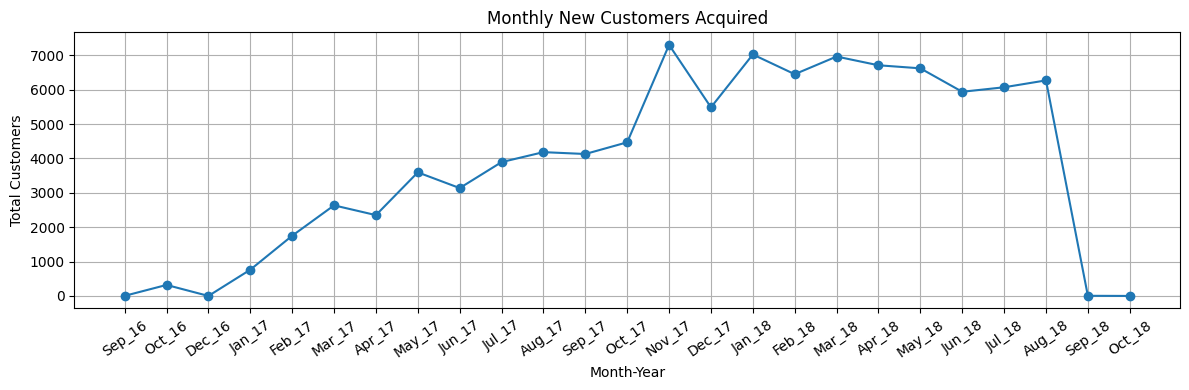

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(result['Month_Yr'], result['Total_New_Customer'], marker='o', linestyle='-')
plt.xlabel('Month-Year')
plt.grid()
plt.ylabel('Total Customers')
plt.title('Monthly New Customers Acquired')
plt.xticks(rotation=35) 
plt.tight_layout()
plt.show()

- Around 7200 customers which is the most ever in a month were gained in the nov_2017.

## c) Understand the retention of customers on month on month basis

**Retention rate** on month on month basis can be defined as no of customers returned (in current month) from previous month divided by the number of customers who were active in previous month.

### How well are we retaining newly acquired customers and the overall customers on month basis??

In [34]:
v=total_cust_and_their_first_orders.Month_Yr.unique()
o_c['month_year']=o_c.order_purchase_timestamp.dt.strftime("%b")+ "_" +o_c.order_purchase_timestamp.dt.strftime("%Y")
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

retention_rate_new_cust={}
retention_rate_total_cust={}

for current_month in v:
    # Split the string into month abbreviation and year
    month_str, year_str = current_month.split('_')
    # Decrement the month by 1
    prev_month_num = (month_mapping[month_str] - 2) % 12 + 1
    # If the month becomes 0 (December), decrement the year
    if prev_month_num == 12:
        prev_year = int(year_str) - 1
    else:
        prev_year = int(year_str)
    # Get the previous month abbreviation
    prev_month_str = [key for key, value in month_mapping.items() if value == prev_month_num][0]
    # Concatenate the previous month abbreviation and year with an underscore
    prev_string_date = f'{prev_month_str}_{prev_year}'
    
    
    if prev_string_date in ["Aug_2016","Nov_2016"]:   # Because there is no data available for these months in our dataset  
        retention_rate_new_cust[current_month]=0
    else:
        current_cohort=pd.Series(o_c[o_c.month_year==current_month].customer_unique_id.unique()) 
        
        '''New customer retention rate calculation'''    
        
        # New Customer in prev month
        prev_cohort=total_cust_and_their_first_orders[total_cust_and_their_first_orders.Month_Yr==prev_string_date].customer_unique_id
        # New customer returned from previous month in current month
        total_cust_returned= prev_cohort.isin(current_cohort).sum()
        retention_rate_new_cust[current_month]=(total_cust_returned/prev_cohort.shape[0])*1000
        
        '''Overall customer retention rate calculation'''
        
        # All the customers active in prev month
        prev_cohort=pd.Series(o_c[o_c.month_year==prev_string_date].customer_unique_id.unique())
        # Customer returned from previous month in current month
        total_cust_returned= prev_cohort.isin(current_cohort).sum()

        retention_rate_total_cust[current_month]=(total_cust_returned/prev_cohort.shape[0])*1000



''' Note: Retention rate is scaled by 1000 for readability. Instead of expressing the retention rate as a fraction of 100, i used 1000,
          which gives the number of returning customers per 1000 customers from the previous month.
          This scaling makes the retention rate easier to interpret, especially because our retention rates
          very small fractions hence providing a clearer picture of customer retention trends.       
'''    

' Note: Retention rate is scaled by 1000 for readability. Instead of expressing the retention rate as a fraction of 100, i used 1000,\n          which gives the number of returning customers per 1000 customers from the previous month.\n          This scaling makes the retention rate easier to interpret, especially because our retention rates\n          very small fractions hence providing a clearer picture of customer retention trends.       \n'

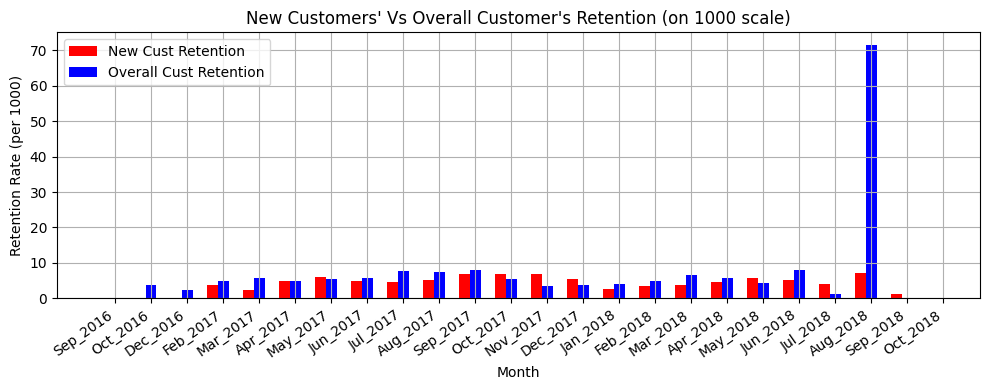

In [36]:
# New Customer RR
monthly_retention=pd.Series(retention_rate_new_cust)
monthly_retention=monthly_retention.reset_index()
monthly_retention.columns=["Month","Retention Rate"]
monthly_retention.Month=pd.to_datetime(monthly_retention.Month,format="%b_%Y")
monthly_retention=monthly_retention.sort_values("Month")
monthly_retention.Month=monthly_retention.Month.dt.strftime("%b_%Y")

# Overall customer RR
monthly_retention_all=pd.Series(retention_rate_total_cust)
monthly_retention_all=monthly_retention_all.reset_index()
monthly_retention_all.columns=["Month","Retention Rate"]
monthly_retention_all.Month=pd.to_datetime(monthly_retention_all.Month,format="%b_%Y")
monthly_retention_all=monthly_retention_all.sort_values("Month")
monthly_retention_all.Month=monthly_retention_all.Month.dt.strftime("%b_%Y")

'''Since for the month of Jan 2017 the overall retention rate is 1000 i.e all the customers from previous month (dec 2016) 
    returned in next month.
    Although it sounds very promising but the fact is, it is only bcz just one customer was active in previous month and it appears 
    that he was also active in the next month hence the existing & new customer retention rate is 1000 of jan 2017.

    Since it is hard to display other month's retention rates on the same plot (due to scaling issue) i am excluding this month from displaying
    in the plot only for the sake of interpretability or better visualization.    
          '''


# Plotting

plt.figure(figsize=(10, 4))
plt.bar(np.arange(monthly_retention[monthly_retention['Month']!="Jan_2017"].Month.shape[0])-0.3, 
        monthly_retention[monthly_retention['Month']!="Jan_2017"]["Retention Rate"],width=0.3,label='New Cust Retention', color='r')

plt.bar(np.arange(monthly_retention_all[monthly_retention_all['Month']!="Jan_2017"].Month.shape[0]),
         monthly_retention_all[monthly_retention_all['Month']!="Jan_2017"]["Retention Rate"],width=0.3,label='Overall Cust Retention', color='b')

plt.xticks(np.arange(monthly_retention[monthly_retention['Month']!="Jan_2017"].shape[0]),monthly_retention[monthly_retention['Month']!="Jan_2017"].Month)

plt.title("New Customers' Vs Overall Customer's Retention (on 1000 scale)")
plt.xlabel('Month')
plt.ylabel('Retention Rate (per 1000)')
plt.legend()
plt.xticks(rotation=35, ha='right')

plt.grid(True)
plt.tight_layout()
plt.show()

- The overall and new customer's retention rate is very low and are nearly equal in most months it indicates the need to look through the marketing channels and strategies used in acquiring the customers.  

## d) How the revenues from existing/new customers on month on month basis

**New Customer Revenue**: The revenue of all the customers who made their first purchase on month basis.

**Existing Customer Revenue**: (Total monthly revenue - new customer revenue), this would be the existing customer revenue on month basis. 



 Monthly revenue for new customers

In [38]:
# Merging the already calculated dataframe (customer who made their first order with us) with o_c dataframe
#  to get all their (new customers') first order_ids so that i can get the payment value for their very fist orders.
df1=pd.merge(total_cust_and_their_first_orders,o_c,how='inner',on=['order_purchase_timestamp','customer_unique_id'])
new_cust=pd.merge(df1,ord_paym,how='inner',on='order_id')

new_cust_rev_monthly= new_cust[new_cust.order_status.isin(["delivered","shipped"])].groupby(["month_year"])["payment_value"].sum()
new_cust_rev_monthly.name='New Customer Revenue'

Monthly revenue for existing customers

In [39]:
temp=pd.merge(o_c,ord_paym,how="inner",on="order_id")
temp=temp[temp.order_status.isin(["delivered","shipped"])]

In [40]:
total_rev_monthly=temp.groupby('month_year').payment_value.sum()
total_rev_monthly=total_rev_monthly.iloc[0:-1]

# Existing customer revenue 
existing_cust_rev_monthly= total_rev_monthly-new_cust_rev_monthly
existing_cust_rev_monthly.name='Existing Customer Revenue'
total_rev_monthly.name='Total Revenue'


In [41]:
# Preparing the two revenue series for plotting

resulting_df=pd.concat([new_cust_rev_monthly,existing_cust_rev_monthly,total_rev_monthly],axis=1)

resulting_df['Existing Cust Rev (in %)']= (resulting_df['Existing Customer Revenue']/ resulting_df['Total Revenue'])* 100

resulting_df['Month']=pd.to_datetime(resulting_df.index,format="%b_%Y")
resulting_df=resulting_df.reset_index()
resulting_df['Month']=pd.to_datetime(resulting_df.month_year,format="%b_%Y")
resulting_df.drop(columns='month_year',inplace=True)
resulting_df=resulting_df.sort_values('Month')
resulting_df.Month=resulting_df.Month.dt.strftime("%b_%y")
resulting_df



,New Customer Revenue,Existing Customer Revenue,Total Revenue,Existing Cust Rev (in %),Month
21,136.23,0.00,136.23,0.000000,Sep_16
19,47719.74,93.72,47813.46,0.196012,Oct_16
4,19.62,0.00,19.62,0.000000,Dec_16
8,129976.57,533.55,130510.12,0.408819,Jan_17
6,274448.41,1113.71,275562.12,0.404159,Feb_17
14,416940.96,2037.31,418978.27,0.486257,Mar_17
0,393648.07,3771.03,397419.10,0.948880,Apr_17
16,566085.47,10020.95,576106.42,1.739427,May_17
12,487388.56,8679.95,496068.51,1.749748,Jun_17
10,561798.22,13243.78,575042.00,2.303098,Jul_17


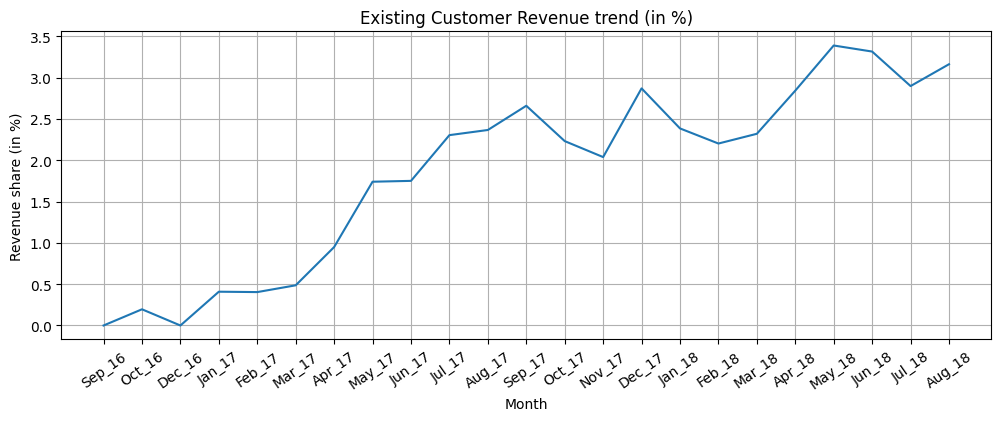

In [42]:
plt.figure(figsize=(12,4))
plt.plot(resulting_df.Month,resulting_df['Existing Cust Rev (in %)'])
plt.title('Existing Customer Revenue trend (in %)')
plt.ylabel('Revenue share (in %)')
plt.xlabel('Month')
plt.grid()
plt.xticks(rotation=35)
plt.show()

- So since the majority of the revenue is contributed only by new customers it means there is potential fluctuations in customer base \
or purchasing behaviour of existing customer base.
- It might be worth evaluating the retention strategies, including loyalty programs, personalized offers, and customer support initiatives, to encourage   repeat purchases from existing customers.

## e) Understand the trends/seasonality of sales, quantity by category, location, month, week, day, time, channel, payment method etc…

In [43]:
# Filtering the dataframe to only succesful orders
''' NOTE: This dataframe (df) will be used in most of the questions throughout this case study.'''

df=o_op[o_op.order_status.isin(['delivered','shipped'])]
df=df.groupby(["order_id","order_purchase_timestamp"]).agg(amount=('payment_value','sum')).reset_index()
df

'''This df basically contains all the orders and their time and amount'''

,order_id,order_purchase_timestamp,amount
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:00,72.19
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:00,259.83
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:00,216.87
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:00,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:00,218.04
...,...,...,...
97579,fffc94f6ce00a00581880bf54a75a037,2018-04-23 13:57:00,343.40
97580,fffcd46ef2263f404302a634eb57f7eb,2018-07-14 10:26:00,386.53
97581,fffce4705a9662cd70adb13d4a31832d,2017-10-23 17:07:00,116.85
97582,fffe18544ffabc95dfada21779c9644f,2017-08-14 23:02:00,64.71


In [44]:
# Making datetime related derived variables for various time related analysis 
df['Month']=df.order_purchase_timestamp.dt.strftime("%b")
df['Month_Yr']=df.order_purchase_timestamp.dt.strftime("%b_%y")
df['Hour']=df.order_purchase_timestamp.dt.strftime("%H")
df['Week_No']=df.order_purchase_timestamp.dt.isocalendar().week
df['Day_of_week']=df.order_purchase_timestamp.dt.day_name().str[:3]

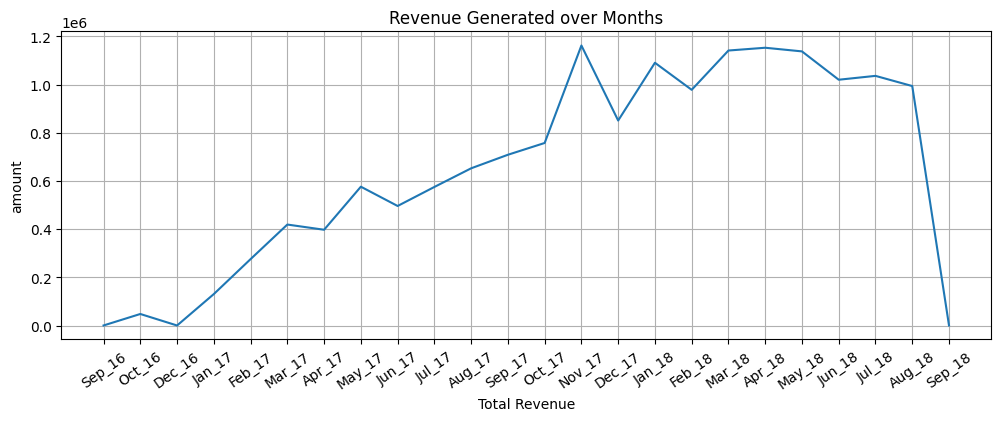

In [45]:
# Total Sales's trend over months.

b=df.groupby('Month_Yr').amount.sum().reset_index()
b['Month_Yr']=pd.to_datetime(b.Month_Yr,format="%b_%y")
b=b.sort_values('Month_Yr')
b['Month_Yr']=b.Month_Yr.dt.strftime("%b_%y")

plt.figure(figsize=(12,4))
sns.lineplot(b,x='Month_Yr',y='amount')
plt.grid(True)
plt.xticks(rotation=35)
plt.xlabel('Total Revenue')
plt.title("Revenue Generated over Months")
plt.show()

- For the year of 2017 there is rising trend in sales. 

- So i will be answering all the questions in this part (e) of the first question for the year of 2017 only 

### Trend period analysis (year 2017)


In [46]:
df_2017=df[df.order_purchase_timestamp.dt.year==2017]
df_2017.head()

,order_id,order_purchase_timestamp,amount,Month,Month_Yr,Hour,Week_No,Day_of_week
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:00,72.19,Sep,Sep_17,08,37,Wed
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:00,259.83,Apr,Apr_17,10,17,Wed
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:00,218.04,Feb,Feb_17,13,5,Sat
5,00048cc3ae777c65dbb7d2a0634bc1ea,2017-05-15 21:42:00,34.59,May,May_17,21,20,Mon
6,00054e8431b9d7675808bcb819fb4a32,2017-12-10 11:53:00,31.75,Dec,Dec_17,11,49,Sun


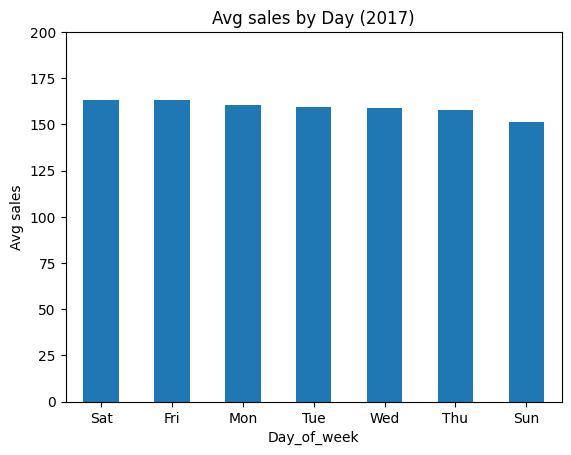

In [47]:
# What is the average sales by day name during the whole year?

df_2017.groupby('Day_of_week').agg(total_amount=('amount','mean')).reset_index().sort_values(by='total_amount',ascending=False).plot(kind='bar',x='Day_of_week')
plt.title('Avg sales by Day (2017)')
plt.ylabel('Avg sales')
plt.legend().set_visible(False)
plt.xticks(rotation=0)
plt.yticks(np.linspace(0,200,9))
plt.show()

The avg sales is highest on saturdays but the avg is nearly equal in all the week days except for sundays it is lowest which seems unusual.

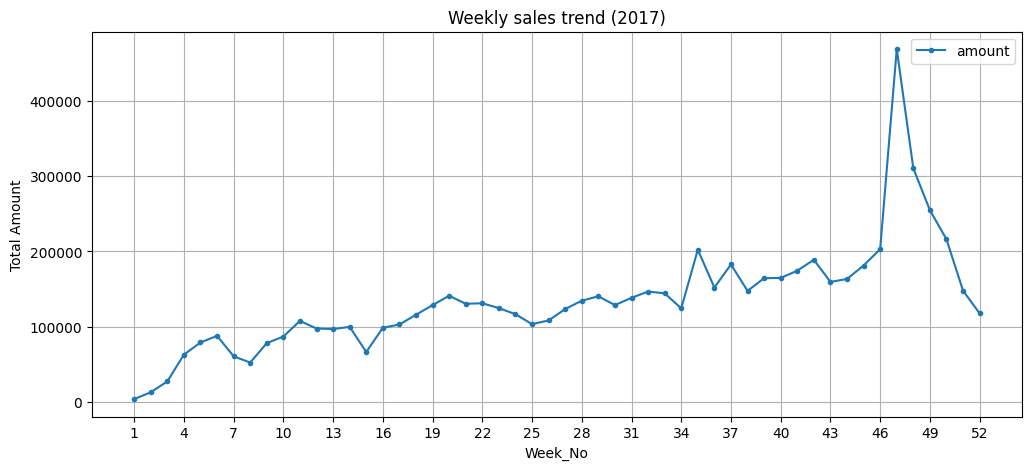

In [48]:
# What is the total weekly sales trend throughout the year?

df_2017.groupby('Week_No').amount.sum().reset_index().plot(kind='line',x='Week_No',y='amount',marker='.',markersize=6,figsize=(12,5))
plt.grid(True)
plt.ylabel('Total Amount')
plt.title('Weekly sales trend (2017)')
plt.xticks(list(range(1,54,3)))
plt.show()

The sales is rising and reaches its peak in the 47th week i.e in the 2nd last week of november. 

It could be due to festival sales during this week.  

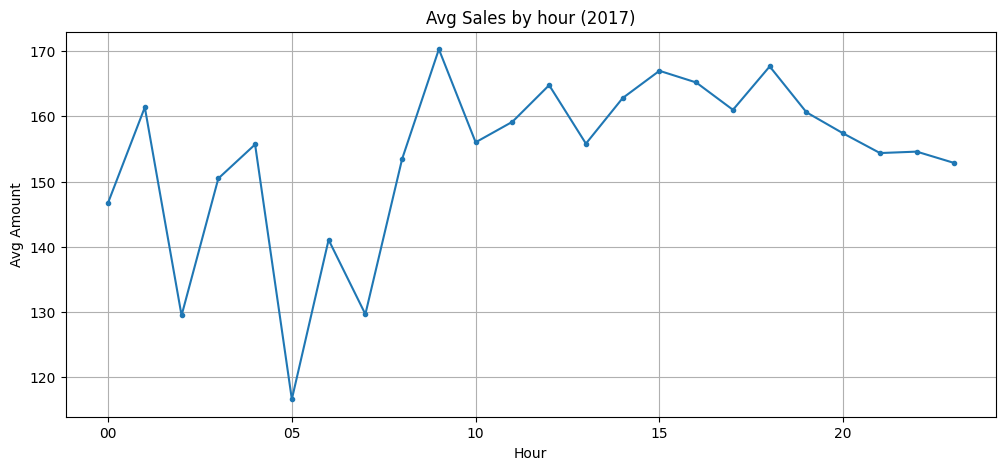

In [49]:
# Lets check how the avg sales vary by 'hour' throughout the year.
df_2017.groupby('Hour').amount.mean().reset_index().plot(kind='line',x='Hour',y='amount',marker='.',markersize=6,figsize=(12,5))
plt.title('Avg Sales by hour (2017)')
plt.ylabel('Avg Amount')
plt.legend().set_visible(False)
plt.grid(True)
plt.show()

So overall avg sales throughout the year (2017) is higher than 150 in most of the hours on any given day. 

In [53]:
prod

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,Perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,Art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,Sports_Leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,Baby,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,Housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,Furniture_Decor,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,Construction_Tools_Lights,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,Bed_Bath_Table,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,Computers_Accessories,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [51]:
# What are the top three categories in 2017 in terms of sales and also show the sales trend of these categories?

cat_df_2017=df_2017.merge(ord_itms,on='order_id').merge(prod,on='product_id')

# Subsetting the columns
cat_df_2017=cat_df_2017[['order_id', 'order_purchase_timestamp', 'amount', 'Month',
       'Month_Yr', 'Hour', 'Day_of_week', 'Week_No', 'order_item_id',
       'product_id', 'seller_id','price',
       'freight_value', 'product_category_name']]
cat_df_2017.head()


'''This cat_df_2017 has information for orders, orders payment, orders item and product.'''

,order_id,order_purchase_timestamp,amount,Month,Month_Yr,Hour,Day_of_week,Week_No,order_item_id,product_id,seller_id,price,freight_value,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:00,72.19,Sep,Sep_17,08,Wed,37,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,Cool_Stuff
1,130898c0987d1801452a8ed92a670612,2017-06-28 11:52:00,73.86,Jun,Jun_17,11,Wed,26,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,Cool_Stuff
2,6f8c31653edb8c83e1a739408b5ff750,2017-08-01 18:38:00,75.07,Aug,Aug_17,18,Tue,31,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,Cool_Stuff
3,7d19f4ef4d04461989632411b7e588b9,2017-08-10 21:48:00,72.19,Aug,Aug_17,21,Thu,32,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,Cool_Stuff
4,a0f9acf0b6294ed8561e32cde1a966bc,2017-07-27 15:11:00,82.83,Jul,Jul_17,15,Thu,30,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,26.93,Cool_Stuff


In [54]:
''' Making a separate amount column as the existing 'amount' column is on order level but 
    since now we have a merged dataframe (with order items) so each row is now at
    individual products (which are ordered with respect to a particular order_id) level. 
    Hence i will use price+freight as the order amount for each product in an order. '''

cat_df_2017['amount_p_f']=cat_df_2017['price']+cat_df_2017['freight_value'] 
top_3_cat_2017=cat_df_2017.groupby(['product_category_name']).amount_p_f.sum().nlargest(3).index
top_3_cat_2017

Index(['Bed_Bath_Table', 'Health_Beauty', 'Sports_Leisure'], dtype='object', name='product_category_name')

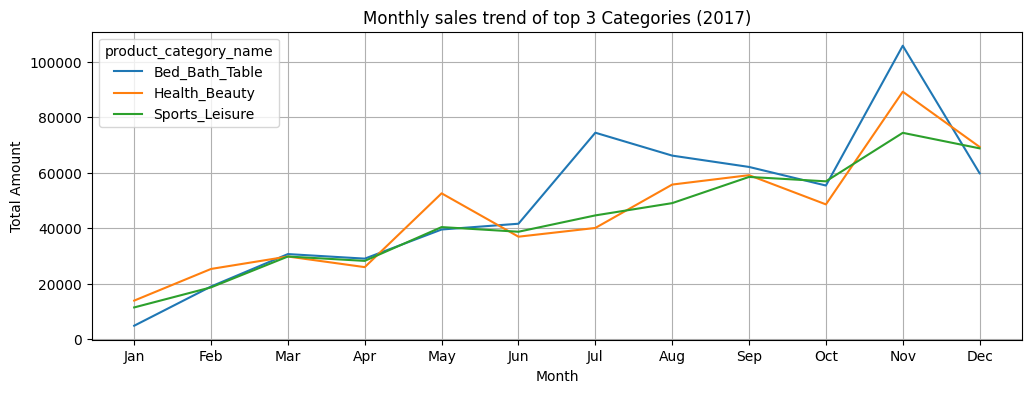

In [55]:
# Lets see the monthly sales trend for the top three categories.
temp=cat_df_2017[cat_df_2017.product_category_name.isin(top_3_cat_2017)].groupby(['product_category_name','Month']).amount_p_f.sum().reset_index()
# For sorting by month:
temp['Month']=pd.to_datetime(temp.Month,format='%b')
temp=temp.sort_values(['product_category_name','Month'])
temp.Month=temp.Month.dt.strftime("%b")

# Plotting
plt.figure(figsize=(12,4))
sns.lineplot(temp,x='Month',y='amount_p_f',hue='product_category_name',markers=True)
plt.title("Monthly sales trend of top 3 Categories (2017)")
plt.grid()
plt.ylabel('Total Amount')
plt.show()

- It can be seen in the peak sales weeks, the bed bath table products are getting sold the most. 

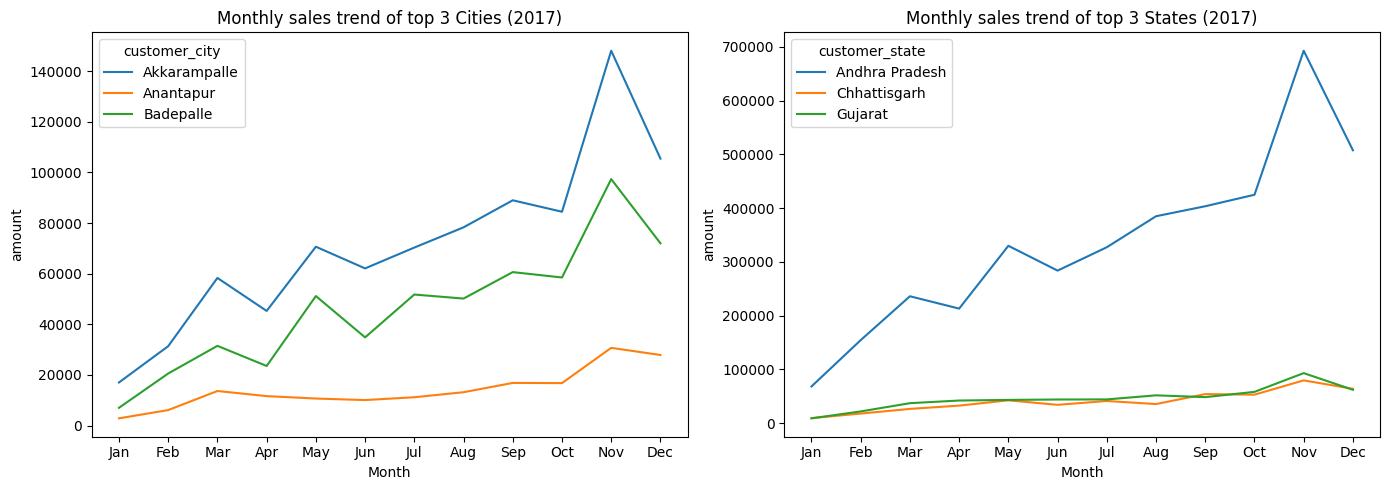

In [56]:
# What are the top three cities and states in 2017 in terms of sales and also show the sales trend of these three cities?

# Creating new dataframe with o_c dataframe based on order_ids in df_2017.  
city_state_df_2017=o_c.loc[o_c.order_id.isin(df_2017.order_id),['order_id','order_purchase_timestamp','customer_city','customer_state']]\
                                                                   .merge(df_2017,on=['order_id','order_purchase_timestamp'])

# FYI the 'amount' column here is on order level. 
top_3_cities=city_state_df_2017.groupby('customer_city').amount.sum().nlargest(3).index
top_3_states=city_state_df_2017.groupby('customer_state').amount.sum().nlargest(3).index

temp1=city_state_df_2017[city_state_df_2017.customer_city.isin(top_3_cities)].groupby(['customer_city','Month']).amount.sum().reset_index()
temp2=city_state_df_2017[city_state_df_2017.customer_state.isin(top_3_states)].groupby(['customer_state','Month']).amount.sum().reset_index()

# Sorting by month for cities
temp1.Month=pd.to_datetime(temp1.Month,format="%b")
temp1=temp1.sort_values(['customer_city','Month'])
temp1.Month=temp1.Month.dt.strftime("%b")

# Sorting by month for states
temp2.Month=pd.to_datetime(temp2.Month,format="%b")
temp2=temp2.sort_values(['customer_state','Month'])
temp2.Month=temp2.Month.dt.strftime("%b")

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,5))
sns.lineplot(temp1,x='Month',y='amount',hue='customer_city',ax=axes[0])
axes[0].set_title('Monthly sales trend of top 3 Cities (2017)')
sns.lineplot(temp2,x='Month',y='amount',hue='customer_state',ax=axes[1])
axes[1].set_title('Monthly sales trend of top 3 States (2017)')
plt.tight_layout()
plt.show()



C:\Users\welcome\AppData\Local\Temp\ipykernel_11864\3540642648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pay_type_df_2017['Month']=pay_type_df_2017.order_purchase_timestamp.dt.strftime("%m")


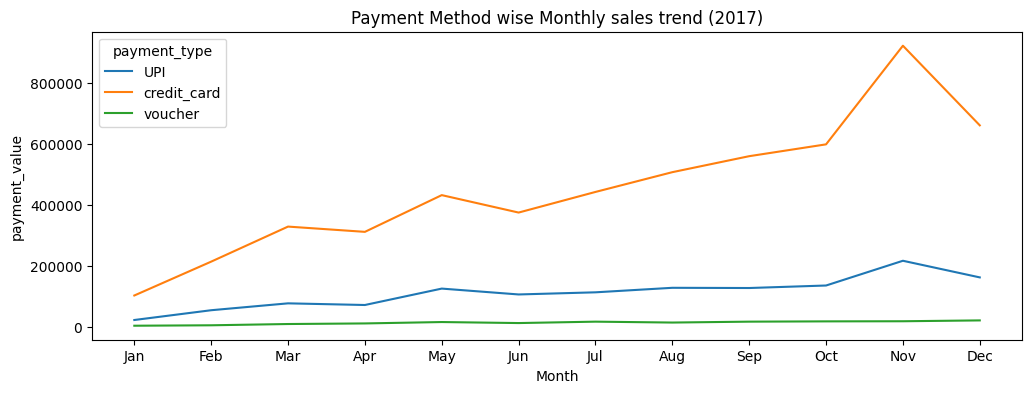

In [57]:
# Payment method wise monthly sales trend in 2017

# Creating new dataframe with o_op dataframe based on order_ids in df_2017 .  
pay_type_df_2017=o_op[o_op.order_id.isin(df_2017.order_id)]
pay_type_df_2017['Month']=pay_type_df_2017.order_purchase_timestamp.dt.strftime("%m")


top_3_payment_methods= pay_type_df_2017.groupby(['payment_type']).payment_value.sum().nlargest(3).index

temp4=pay_type_df_2017[pay_type_df_2017.payment_type.isin(top_3_payment_methods)].groupby(['payment_type','Month']).payment_value.sum().reset_index()
temp4.Month=pd.to_datetime(temp4.Month,format='%m')
temp4.Month=temp4.Month.dt.strftime("%b")

# Plotting
plt.figure(figsize=(12,4))
sns.lineplot(temp4,x='Month',y='payment_value',hue='payment_type',markers=True)
plt.title("Payment Method wise Monthly sales trend (2017)")
plt.show()

In [68]:
cat_df_2017

,order_id,order_purchase_timestamp,amount,Month,Month_Yr,Hour,Day_of_week,Week_No,order_item_id,product_id,seller_id,price,freight_value,product_category_name,amount_p_f
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:00,72.19,Sep,Sep_17,08,Wed,37,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,Cool_Stuff,72.19
1,130898c0987d1801452a8ed92a670612,2017-06-28 11:52:00,73.86,Jun,Jun_17,11,Wed,26,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,Cool_Stuff,73.86
2,6f8c31653edb8c83e1a739408b5ff750,2017-08-01 18:38:00,75.07,Aug,Aug_17,18,Tue,31,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,Cool_Stuff,75.07
3,7d19f4ef4d04461989632411b7e588b9,2017-08-10 21:48:00,72.19,Aug,Aug_17,21,Thu,32,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,Cool_Stuff,72.19
4,a0f9acf0b6294ed8561e32cde1a966bc,2017-07-27 15:11:00,82.83,Jul,Jul_17,15,Thu,30,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,26.93,Cool_Stuff,82.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50117,ffe4b41e99d39f0b837a239110260530,2017-08-31 21:15:00,69.58,Aug,Aug_17,21,Thu,35,2,e97df839917a6e93404867b1d0319bfc,42bde9fef835393bb8a8849cb6b7f245,19.0,15.79,Toys,34.79
50118,ffea406a848c8afe4dec22bf6290ba00,2017-03-15 17:16:00,162.10,Mar,Mar_17,17,Wed,11,1,801a695ff5c0c14970a71a4ceb70989e,48162d548f5b1b11b9d29d1e01f75a61,146.9,15.20,Home_Construction,162.10
50119,fff6889749958e42b47a7977a4cf0ea0,2017-09-25 22:41:00,123.60,Sep,Sep_17,22,Mon,39,1,75f6a4f019ec1322758d53b2fee2cc12,058cb5aeb36d7c0fcae20fc85d5e0a59,92.0,31.60,Luggage_Accessories,123.60
50120,fff7c4452f050315db1b3f24d9df5fcd,2017-06-01 16:53:00,756.91,Jun,Jun_17,16,Thu,22,1,dd469c03ad67e201bc2179ef077dcd48,7e93a43ef30c4f03f38b393420bc753a,736.0,20.91,Watches_Gifts,756.91


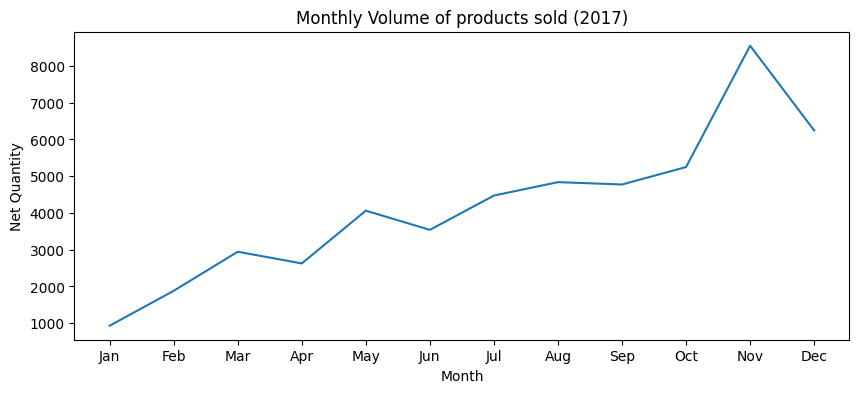

In [64]:
#  Volume of products sold monthly in 2017?
''' To get the quantity of units sold in an order i used 'order_item_id' column from order_items table.
    Since i already have cat_df_2017 dataframe which is on product level so i can easily get the 
    quantity or units purchased per order as can be seen in the code below.  
 '''

qty_calculation=cat_df_2017.groupby(['order_id']).order_item_id.max().sort_values(ascending=False).reset_index()
# Renaming columns
qty_calculation.columns=['order_id']+['quantity']

# Merging the df with qty back with order table (ord) on order id to get the datetime for monthly comparison of qty sold.
qty_vol_df_2017=qty_calculation.merge(ord,on='order_id')[['order_id','order_purchase_timestamp','quantity']]
qty_vol_df_2017['Month']=qty_vol_df_2017.order_purchase_timestamp.dt.strftime('%b')

# Calculation for monthly volume of products ordered in 2017
temp5=qty_vol_df_2017.groupby('Month').quantity.sum().reset_index()
# Sorting by month
temp5.Month=pd.to_datetime(temp5.Month,format="%b")
temp5=temp5.sort_values('Month')
temp5.Month=temp5.Month.dt.strftime("%b")

# Plotting
temp5.plot(kind='line',x='Month',y='quantity',figsize=(10,4))
plt.title('Monthly Volume of products sold (2017)')
plt.xlabel('Month')
plt.legend().set_visible(False)
plt.xticks(range(len(temp5['Month'])), temp5['Month'])
plt.ylabel("Net Quantity")
plt.show()

In [66]:
# Top 3 category wise monthly quantity sold?

''' Calculating the category wise total qty ordered per order id and then merging the resulting df with df_2017 on order_id.
     This ensures that i can simply do grouping on month and take the sum of 'quantity_by_cat' and i will be getting the monthly qty.
'''
cat_level_qty_calculation = cat_df_2017.groupby(['order_id','product_category_name']).size().sort_values(ascending=False).reset_index()
cat_level_qty_calculation.columns=['order_id','product_category_name','quantity_by_cat']

cat_qty_df_2017=cat_level_qty_calculation.merge(df_2017,on='order_id')
cat_qty_df_2017

,order_id,product_category_name,quantity_by_cat,order_purchase_timestamp,amount,Month,Month_Yr,Hour,Week_No,Day_of_week
0,8272b63d03f5f79c56e9e4120aec44ef,Health_Beauty,21,2017-07-16 18:19:00,196.11,Jul,Jul_17,18,28,Sun
1,ab14fdcfbe524636d65ee38360e22ce8,Auto,20,2017-08-23 09:22:00,2262.80,Aug,Aug_17,09,34,Wed
2,428a2f660dc84138d969ccd69a0ab6d5,Furniture_Decor,15,2017-11-23 20:30:00,1225.65,Nov,Nov_17,20,47,Thu
3,9ef13efd6949e4573a18964dd1bbe7f5,Garden_Tools,15,2017-01-30 21:44:00,783.00,Jan,Jan_17,21,5,Mon
4,73c8ab38f07dc94389065f7eba4f297a,Garden_Tools,14,2017-12-13 14:21:00,1014.02,Dec,Dec_17,14,50,Wed
...,...,...,...,...,...,...,...,...,...,...
43493,5a45e21be984a22a54a63a7e950c2f0e,Toys,1,2017-11-16 13:40:00,291.49,Nov,Nov_17,13,46,Thu
43494,5a4622fea27ea392ef817c16c9aa3da7,Telephony,1,2017-11-20 20:12:00,26.85,Nov,Nov_17,20,47,Mon
43495,5a4761b64c03fa0c4663d7ebba05bc33,Bed_Bath_Table,1,2017-07-03 18:04:00,40.00,Jul,Jul_17,18,27,Mon
43496,5a4ae77af140c48f0cd65b631bdcb342,Sports_Leisure,1,2017-08-05 14:55:00,107.48,Aug,Aug_17,14,31,Sat


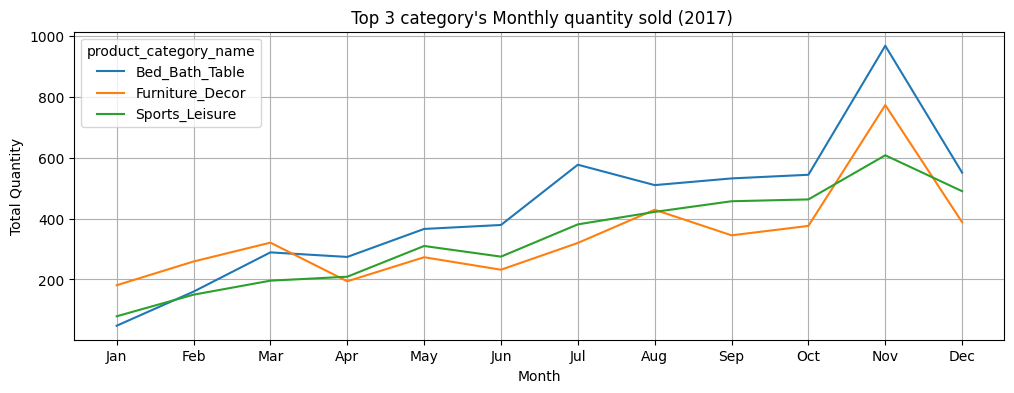

In [67]:
top_3_cat_by_qty=cat_qty_df_2017.groupby('product_category_name').quantity_by_cat.sum().nlargest(3).index
temp6=cat_qty_df_2017[cat_qty_df_2017.product_category_name.isin(top_3_cat_by_qty)].groupby(['product_category_name','Month']).quantity_by_cat.sum().reset_index()

# Sorting by month
temp6.Month=pd.to_datetime(temp6.Month,format="%b")
temp6=temp6.sort_values(['product_category_name','Month'])
temp6.Month=temp6.Month.dt.strftime('%b')

# Plotting
plt.figure(figsize=(12,4))
sns.lineplot(temp6,hue='product_category_name',x='Month',y='quantity_by_cat')
plt.grid()
plt.title(" Top 3 category's Monthly quantity sold (2017)")
plt.ylabel('Total Quantity')
plt.show()

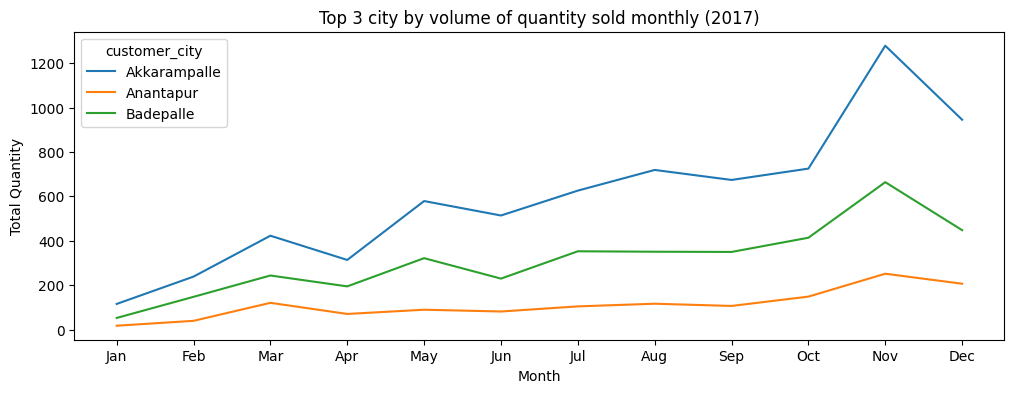

In [340]:
# What is the monthly volume of product sold in top three cities in terms of volume?

''' Here i can use the already calculated dataframe 'qty_calculation' as this is calculated on order level 
    i.e neither on category level (as we did in prev question) nor on product level(which i will do if needed) 
    and since we are only concerned on volume so it is usable here.
'''


city_qty_df_2017=qty_calculation.merge(df_2017,on='order_id').merge(o_c,on='order_id')

top_3_city_by_qty=city_qty_df_2017.groupby(['customer_city']).quantity.sum().nlargest(3).index
temp7=city_qty_df_2017[city_qty_df_2017.customer_city.isin(top_3_city_by_qty)].groupby(['customer_city','Month']).quantity.sum().reset_index()

# Sorting
temp7.Month=pd.to_datetime(temp7.Month,format="%b")
temp7=temp7.sort_values(['customer_city','Month'])
temp7.Month=temp7.Month.dt.strftime('%b')
# Plotting
plt.figure(figsize=(12,4))
sns.lineplot(temp7,hue='customer_city',x='Month',y='quantity')
plt.title("Top 3 city by volume of quantity sold monthly (2017)")
plt.ylabel('Total Quantity')
plt.show()

## f) Popular Products by month, seller, state, category.

In [74]:
# Popular product by month

'''Here i am calculating qty on product level (just like i did in prev question on category level).'''

qty_cal_on_prod_level=df.merge(ord_itms,on='order_id').groupby(['order_id','product_id']).size().reset_index()
qty_cal_on_prod_level.columns=['order_id']+['product_id']+['quantity']

df2=qty_cal_on_prod_level.merge(df,on='order_id')
df2

,order_id,product_id,quantity,order_purchase_timestamp,amount,Month,Month_Yr,Hour,Week_No,Day_of_week
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,2017-09-13 08:59:00,72.19,Sep,Sep_17,08,37,Wed
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,2017-04-26 10:53:00,259.83,Apr,Apr_17,10,17,Wed
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,2018-01-14 14:33:00,216.87,Jan,Jan_18,14,2,Sun
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,2018-08-08 10:00:00,25.78,Aug,Aug_18,10,32,Wed
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,2017-02-04 13:57:00,218.04,Feb,Feb_17,13,5,Sat
...,...,...,...,...,...,...,...,...,...,...
101317,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,1,2018-04-23 13:57:00,343.40,Apr,Apr_18,13,17,Mon
101318,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,1,2018-07-14 10:26:00,386.53,Jul,Jul_18,10,28,Sat
101319,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,1,2017-10-23 17:07:00,116.85,Oct,Oct_17,17,43,Mon
101320,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,1,2017-08-14 23:02:00,64.71,Aug,Aug_17,23,33,Mon


In [79]:
x1=df2.groupby(["Month_Yr",'product_id']).quantity.sum().sort_values(ascending=False).reset_index()
# Picking the monthly top product by qty
idx = x1.groupby('Month_Yr')['quantity'].idxmax()
top_products_by_month = x1.loc[idx]
top_products_by_month.sort_values('quantity',ascending=False)

,Month_Yr,product_id,quantity
0,Jan_18,aca2eb7d00ea1a7b8ebd4e68314663af,122
1,May_18,53b36df67ebb7c41585e8d54d6772e08,114
3,Nov_17,422879e10f46682990de24d770e7f83d,91
5,Apr_18,53b36df67ebb7c41585e8d54d6772e08,85
9,Jun_17,42a2c92a0979a949ca4ea89ec5c7b934,73
10,Feb_18,e53e557d5a159f5aa2c5e995dfdf244b,71
13,Mar_18,aca2eb7d00ea1a7b8ebd4e68314663af,65
14,Aug_18,e7cc48a9daff5436f63d3aad9426f28b,64
15,Jul_17,99a4788cb24856965c36a24e339b6058,60
18,May_17,99a4788cb24856965c36a24e339b6058,58


In [92]:
# Popular product by category
x2=o_oi_p[o_oi_p.order_id.isin(df.order_id)].groupby(['product_category_name','product_id']).size().sort_values(ascending=False).reset_index()
x2.columns=['product_category_name','product_id','quantity']

# # Picking the top product by qty by category
idx = x2.groupby('product_category_name')['quantity'].idxmax()
top_products_by_cat = x2.loc[idx]
top_products_by_cat.sort_values('quantity',ascending=False)

,product_category_name,product_id,quantity
0,Furniture_Decor,aca2eb7d00ea1a7b8ebd4e68314663af,527
1,Bed_Bath_Table,99a4788cb24856965c36a24e339b6058,486
2,Garden_Tools,422879e10f46682990de24d770e7f83d,484
6,Computers_Accessories,d1c427060a0f73f6b889a5c7c61f2ac4,341
7,Watches_Gifts,53b36df67ebb7c41585e8d54d6772e08,323
...,...,...,...
3928,Dvds_Blu_Ray,8ac47b3ab13c68f49f10dde899674149,5
5556,Music,4befae07dba4384f6d8237ad1e7f8294,4
6225,Fashion_Childrens_Clothes,57bdf3098169cccdb62221bd3e089cbd,3
8267,La_Cuisine,33900d427fa4bd3f509cdacda72e84a3,3


In [343]:
# Popular product by state

df2=ord_itms[ord_itms.order_id.isin(df.order_id)].merge(o_c[['order_id','customer_unique_id','customer_state','customer_city']],on='order_id')
x3 =df2.groupby(["customer_state",'product_id']).size().sort_values(ascending=False).reset_index()
x3.columns=['customer_state','product_id','quantity']


# Picking the top product by qty in each state
idx = x3.groupby('customer_state')['quantity'].idxmax()
top_products_by_state = x3.loc[idx]
top_products_by_state.sort_values('quantity',ascending=False)

,customer_state,product_id,quantity
0,Andhra Pradesh,aca2eb7d00ea1a7b8ebd4e68314663af,345
93,Gujarat,53759a2ecddad2bb87a079a1f1519f73,45
110,Chhattisgarh,368c6c730842d78016ad823897a372db,40
279,Karnataka,422879e10f46682990de24d770e7f83d,24
325,Delhi,53759a2ecddad2bb87a079a1f1519f73,22
466,Madhya Pradesh,99a4788cb24856965c36a24e339b6058,17
560,Jammu & Kashmir,89b190a046022486c635022524a974a8,15
678,Tamil Nadu,99a4788cb24856965c36a24e339b6058,13
732,Maharashtra,99a4788cb24856965c36a24e339b6058,13
680,Kerala,aca2eb7d00ea1a7b8ebd4e68314663af,13


In [344]:
# Popular product by seller
x4=o_oi_s[o_oi_s.order_id.isin(df.order_id)].groupby(['seller_id','product_id']).size().sort_values(ascending=False).reset_index()
x4.columns=['seller_id','product_id','quantity']

# Picking the top product by qty for each seller
idx = x4.groupby('seller_id')['quantity'].idxmax()
top_products_by_seller = x4.loc[idx]
top_products_by_seller.sort_values('quantity',ascending=False)

,seller_id,product_id,quantity
0,955fee9216a65b617aa5c0531780ce60,aca2eb7d00ea1a7b8ebd4e68314663af,527
1,1f50f920176fa81dab994f9023523100,422879e10f46682990de24d770e7f83d,484
2,4a3ca9315b744ce9f8e9374361493884,99a4788cb24856965c36a24e339b6058,480
6,a1043bafd471dff536d0c462352beb48,d1c427060a0f73f6b889a5c7c61f2ac4,341
7,cc419e0650a3c5ba77189a1882b7556a,154e7e31ebfa092203795c972e5804a6,281
...,...,...,...
22442,398cb257329ef7af7f1943a8974a3cbc,731cf6fbf44cc64a9583fabe2c00750e,1
22443,3986c0b54f6b748b75e7bd4e092aa3e5,c4d9e2052eaa16ff448ebaac4fa37129,1
29739,95cca791657aabeff15a07eb152d7841,9a46ea3c561cf8075d59a39256461e73,1
31577,62de60d81c55c29d76a6bce418b31cef,9e25ada324eae24218829873a10d95ee,1


## g) Popular categories by state, month

In [93]:
# Popular categories by month
x=o_oi_p[o_oi_p.order_id.isin(df.order_id)]
res=x.groupby([x.order_purchase_timestamp.dt.strftime("%b_%y"),'product_category_name']).agg(quantity=('order_item_id','size')).sort_values('quantity',ascending=False).reset_index()
res.columns=['Month','Category','quantity']

# Picking the top product by qty for each seller
idx = res.groupby('Month')['quantity'].idxmax()
top_products_by_seller = res.loc[idx]
top_products_by_seller.sort_values('quantity',ascending=False)

,Month,Category,quantity
0,Feb_18,Computers_Accessories,975
1,Nov_17,Bed_Bath_Table,968
2,Jun_18,Health_Beauty,884
3,Jan_18,Bed_Bath_Table,845
4,Aug_18,Health_Beauty,841
5,Mar_18,Bed_Bath_Table,795
6,Jul_18,Health_Beauty,781
9,May_18,Health_Beauty,760
13,Apr_18,Bed_Bath_Table,745
35,Jul_17,Bed_Bath_Table,577


In [395]:
# Popular categories by state

o_oi_p_c=o_oi_p.merge(cust,on='customer_id')
xx=o_oi_p_c[o_oi_p_c.order_id.isin(df.order_id)]
res=xx.groupby(['customer_state','product_category_name']).agg(quantity=('order_item_id','size')).sort_values('quantity',ascending=False).reset_index()
res.columns=['State','Category','quantity'] 


# Picking the top product by qty for each seller
idx = res.groupby('State')['quantity'].idxmax()
top_categories_by_state = res.loc[idx]
top_categories_by_state.sort_values('quantity',ascending=False)

,State,Category,quantity
0,Andhra Pradesh,Bed_Bath_Table,7068
19,Gujarat,Bed_Bath_Table,783
21,Chhattisgarh,Bed_Bath_Table,680
38,Karnataka,Bed_Bath_Table,378
46,Delhi,Health_Beauty,327
51,Madhya Pradesh,Bed_Bath_Table,318
58,Haryana,Bed_Bath_Table,282
79,Maharashtra,Bed_Bath_Table,213
80,Tamil Nadu,Bed_Bath_Table,211
110,Jammu & Kashmir,Bed_Bath_Table,160


## h) List top 10 most expensive products sorted by price

In [346]:
ord_itms.groupby('product_id').price.mean().nlargest(10).reset_index()


,product_id,price
0,489ae2aa008f021502940f251d4cce7f,6735.00
1,69c590f7ffc7bf8db97190b6cb6ed62e,6729.00
2,1bdf5e6731585cf01aa8169c7028d6ad,6499.00
3,a6492cc69376c469ab6f61d8f44de961,4799.00
4,c3ed642d592594bb648ff4a04cee2747,4690.00
5,259037a6a41845e455183f89c5035f18,4590.00
6,a1beef8f3992dbd4cd8726796aa69c53,4399.87
7,6cdf8fc1d741c76586d8b6b15e9eef30,4099.99
8,6902c1962dd19d540807d0ab8fade5c6,3999.90
9,4ca7b91a31637bd24fb8e559d5e015e4,3999.00


# 2) Performing Customers/sellers Segmentation

## Divide the customers into groups based on the revenue generated

In [94]:
temp_1=o_c[o_c.order_id.isin(df.order_id)].merge(ord_paym,on='order_id')
cust_revenue=temp_1.groupby('customer_unique_id').payment_value.sum().reset_index()

<Axes: xlabel='payment_value', ylabel='Density'>

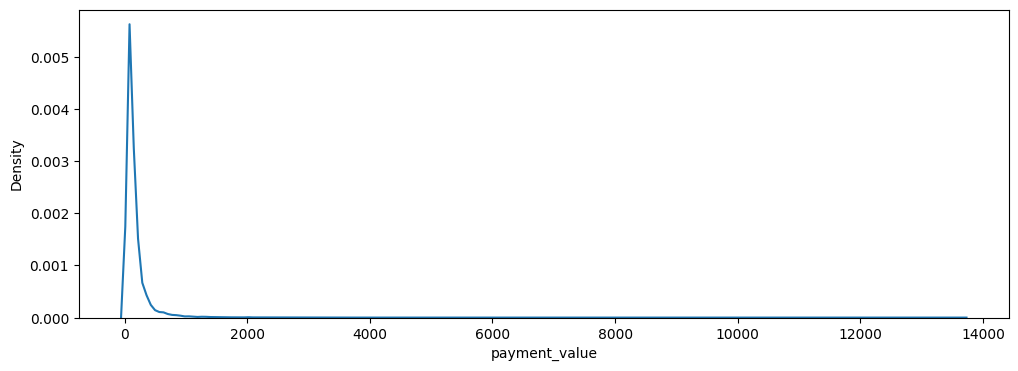

In [95]:
# Checking the distribution of revenue of customers
plt.figure(figsize=(12,4))
sns.kdeplot(x=cust_revenue['payment_value'])

clearly the revenue is right skewed normal distribution just like any wealth related data.

In [96]:
quintiles_segments=pd.qcut(cust_revenue.payment_value,5,['Frugal Spender','Moderate Spender','Average Spender','Comfortable Spender','High-End Spender'])

In [97]:
quintiles_segments.value_counts()

Frugal Spender         18887
High-End Spender       18880
Average Spender        18879
Comfortable Spender    18879
Moderate Spender       18873
Name: payment_value, dtype: int64

In [98]:
cust_segments=pd.concat([cust_revenue,quintiles_segments],axis=1)
cust_segments.columns=['customer_unique_id','Total Revenue Generated','segment']
cust_segments

,customer_unique_id,Total Revenue Generated,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,Comfortable Spender
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,Frugal Spender
2,0000f46a3911fa3c0805444483337064,86.22,Moderate Spender
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,Frugal Spender
4,0004aac84e0df4da2b147fca70cf8255,196.89,Comfortable Spender
...,...,...,...
94393,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,High-End Spender
94394,fffea47cd6d3cc0a88bd621562a9d061,84.58,Moderate Spender
94395,ffff371b4d645b6ecea244b27531430a,112.46,Average Spender
94396,ffff5962728ec6157033ef9805bacc48,133.69,Comfortable Spender


## Divide the sellers into groups based on the revenue generated

In [99]:
''' The seller revenue will be based on the price of the product.'''
seller_revenue=o_oi_s[o_oi_s.order_id.isin(df.order_id)].groupby('seller_id')['price'].sum().reset_index()

<Axes: xlabel='price', ylabel='Density'>

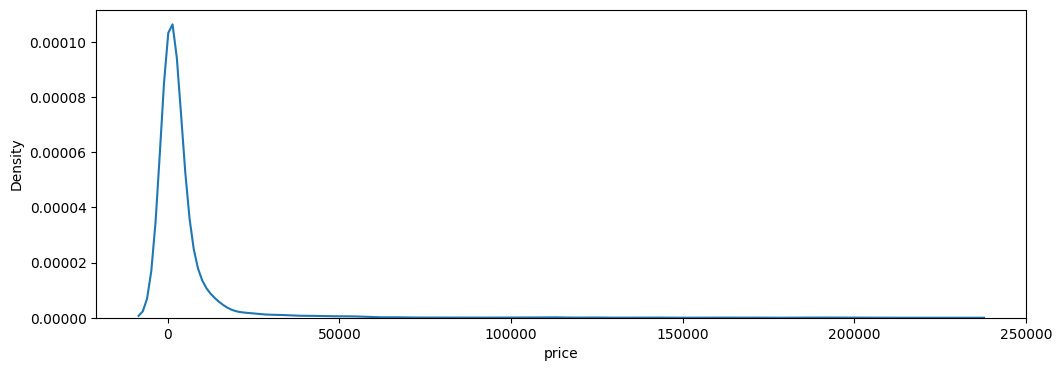

In [100]:
plt.figure(figsize=(12,4))
sns.kdeplot(x=seller_revenue['price'])

In [101]:
quintiles_sell_segments=pd.qcut(seller_revenue.price,5,['Novice Seller','Progressing Seller','Core Seller','Elite Seller','Premier Seller'])
quintiles_sell_segments.value_counts()


Novice Seller         596
Core Seller           596
Premier Seller        596
Progressing Seller    595
Elite Seller          594
Name: price, dtype: int64

In [102]:
seller_segments=pd.concat([seller_revenue,quintiles_sell_segments],axis=1)
seller_segments.columns=['Seller_id','Total Revenue','Segment']
seller_segments

,Seller_id,Total Revenue,Segment
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,Elite Seller
1,001cca7ae9ae17fb1caed9dfb1094831,25080.03,Premier Seller
2,002100f778ceb8431b7a1020ff7ab48f,1234.50,Core Seller
3,003554e2dce176b5555353e4f3555ac8,120.00,Novice Seller
4,004c9cd9d87a3c30c522c48c4fc07416,19712.71,Premier Seller
...,...,...,...
2972,ffc470761de7d0232558ba5e786e57b7,1649.01,Elite Seller
2973,ffdd9f82b9a447f6f8d4b91554cc7dd3,2101.20,Elite Seller
2974,ffeee66ac5d5a62fe688b9d26f83f534,1839.86,Elite Seller
2975,fffd5413c0700ac820c7069d66d98c89,8962.50,Premier Seller


# 3) Cross-Selling (Which products are selling together)

 Cross selling is when a customer places an order with cart containing products from different categories **(cross-category purchase)** \
  also when different products are ordered from same category **(cross-orders within a category)** like phone1 and phone2 both are \
  in same category i.e they may differ in brand but not in category.
  

### Top 10 product_ids selling in combinations i.e cross-selling 

In [104]:
o_oi

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,10/6/2017 11:07,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,7/26/2018 3:24,7/26/2018 14:31,8/7/2018 15:27,8/13/2018 0:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,7/30/2018 3:24,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,8/8/2018 8:55,8/8/2018 13:50,8/17/2018 18:06,9/4/2018 0:00,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,8/13/2018 8:55,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,11/18/2017 19:45,11/22/2017 13:39,12/2/2017 0:28,12/15/2017 0:00,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,11/23/2017 19:45,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,2/13/2018 22:20,2/14/2018 19:46,2/16/2018 18:17,2/26/2018 0:00,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2/19/2018 20:31,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:00,2/6/2018 13:10,2/7/2018 23:22,2/28/2018 17:37,3/2/2018 0:00,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2/12/2018 13:10,174.90,20.10
112646,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:00,8/27/2017 15:04,8/28/2017 20:52,9/21/2017 11:24,9/27/2017 0:00,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,9/5/2017 15:04,205.99,65.02
112647,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:00,1/8/2018 21:36,1/12/2018 15:35,1/25/2018 23:32,2/15/2018 0:00,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,1/12/2018 21:36,179.99,40.59
112648,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:00,1/8/2018 21:36,1/12/2018 15:35,1/25/2018 23:32,2/15/2018 0:00,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,1/12/2018 21:36,179.99,40.59


In [108]:
filtered_oi.groupby('order_id').size()>1

order_id
0008288aa423d2a3f00fcb17cd7d8719    True
00143d0f86d6fbd9f9b38ab440ac16f5    True
001ab0a7578dd66cd4b0a71f5b6e1e41    True
001d8f0e34a38c37f7dba2a37d4eba8b    True
002c9def9c9b951b1bec6d50753c9891    True
                                    ... 
ffd84ab39cd5e873d8dba24342e65c01    True
ffe4b41e99d39f0b837a239110260530    True
ffecd5a79a0084f6a592288c67e3c298    True
fff8287bbae429a99bb7e8c21d151c41    True
fffb9224b6fc7c43ebb0904318b10b5f    True
Length: 9696, dtype: bool

In [111]:
# Filtering rows that corresponds to delivered orders where multiple items were purchased or where order_item_id is more than 1 

filtered_oi= o_oi_p[o_oi_p.order_id.isin(df.order_id)]
b=filtered_oi.groupby('order_id').size()>1
filtered_oi=filtered_oi[filtered_oi.order_id.isin(b[b].index)]

print(filtered_oi.order_id.nunique() ) 

''' So a total of 9696 orders were placed where more than one item was purchased irrespective of how many category type or product types (product_id)'''


9696


' So a total of 9696 orders were placed where more than one item was purchased irrespective of how many category type or product types (product_id)'

In [113]:
'''Just filter out those order ids where multiple (more than 1) products are ordered.'''

p=filtered_oi.groupby(['order_id','product_id']).size().sort_values().reset_index()
# filtering
condition_for_ord_with_2_or_more_p_id=p.order_id.value_counts().sort_values()>1
cross_orders=p[p.order_id.isin(    condition_for_ord_with_2_or_more_p_id[  condition_for_ord_with_2_or_more_p_id  ].index    )]

'''There are 3218 orders where cross selling of products were done.
    Out of 32951 products only 4856 were part of cross selling orders.
         '''

'There are 3218 orders where cross selling of products were done.\n    Out of 32951 products only 4856 were part of cross selling orders.\n         '

In [115]:
import itertools

'''
    Now all we need is to make 2 and 3 combinations of product ids per order by using the combinations function. 
    Followed by that making chain on all the possible combination of 2 or 3 and storing them in combinations list.

    And then we can simply count the number of times each combination has appeared.
'''

dff=cross_orders.copy()

grouped_data = dff.groupby('order_id')['product_id'].apply(list)

combinations = []
for products in grouped_data:
    if len(products) >= 2:
        combos = itertools.chain.from_iterable(
            itertools.combinations(products, r) for r in range(2, min(4, len(products) + 1)))
        combinations.extend(combos)

combo_count = {}
for combo in combinations:
    combo = tuple(sorted(combo))
    combo_count[combo] = combo_count.get(combo, 0) + 1

top_combinations_prod_id = sorted(combo_count.items(), key=lambda x: x[1], reverse=True)[:10]


In [359]:
top_combinations_prod_id

[(('36f60d45225e60c7da4558b070ce4b60', 'e53e557d5a159f5aa2c5e995dfdf244b'),
  34),
 (('35afc973633aaeb6b877ff57b2793310', '99a4788cb24856965c36a24e339b6058'),
  29),
 (('4fcb3d9a5f4871e8362dfedbdb02b064', 'f4f67ccaece962d013a4e1d7dc3a61f7'),
  17),
 (('36f60d45225e60c7da4558b070ce4b60', '3f14d740544f37ece8a9e7bc8349797e'),
  12),
 (('389d119b48cf3043d311335e499d9c6b', '422879e10f46682990de24d770e7f83d'),
  11),
 (('389d119b48cf3043d311335e499d9c6b', '53759a2ecddad2bb87a079a1f1519f73'), 9),
 (('368c6c730842d78016ad823897a372db', '53759a2ecddad2bb87a079a1f1519f73'), 8),
 (('18486698933fbb64af6c0a255f7dd64c', 'dbb67791e405873b259e4656bf971246'), 7),
 (('422879e10f46682990de24d770e7f83d', '53759a2ecddad2bb87a079a1f1519f73'), 7),
 (('060cb19345d90064d1015407193c233d', '98d61056e0568ba048e5d78038790e77'), 6)]

### Top 10 categories in Cross-category purchase

In [118]:
'''Just filter out those order ids where multiple (more than 1) category's product purchased in an order.'''

pp=filtered_oi.groupby(['order_id','product_category_name']).size().sort_values().reset_index()

# Filtering for cross-category orders
conddd=pp.order_id.value_counts().sort_values()>1
cross_orders=pp[pp.order_id.isin(conddd[conddd].index)]
cross_orders.order_id.nunique(),cross_orders.product_category_name.nunique()

'''Total 725 orders are their in which cross-category purchases were made. 
   Out of 72 total categories only 60 among them were part of the cross-category purchase.'''



(725, 60)

In [119]:
# Two combination wise cross-selling between categories
from itertools import combinations
all_comb_=list(combinations(cross_orders.product_category_name.unique(),2))
x_=cross_orders.groupby('order_id')['product_category_name'].apply(list).reset_index()
tuple_dict = {tuple_pair: 0 for tuple_pair in all_comb_}

for i in x_.index:
  comb=list(combinations(x_.at[i,'product_category_name'],2))
  for c in comb:
    for key in tuple_dict.keys():
      c1=c[0]
      c2=c[1]
      if (c1 in key) and (c2 in key):
        tuple_dict[key]+=1

Total_cat_combinations=pd.Series(tuple_dict)        

In [120]:
# Top 10 category pairs which are ordered simultaneously in an order
Total_cat_combinations=Total_cat_combinations.nlargest(10).reset_index()
Total_cat_combinations.columns=['Cat_1','Cat_2','No of times the combination Bought']
Total_cat_combinations

,Cat_1,Cat_2,No of times the combination Bought
0,Bed_Bath_Table,Furniture_Decor,70
1,Home_Confort,Bed_Bath_Table,43
2,Housewares,Furniture_Decor,24
3,Housewares,Bed_Bath_Table,20
4,Cool_Stuff,Baby,20
5,Baby,Toys,19
6,Garden_Tools,Furniture_Decor,17
7,Bed_Bath_Table,Baby,17
8,Sports_Leisure,Health_Beauty,14
9,Furniture_Decor,Home_Construction,13


# 4) Payment Behaviour

a. How customers are paying?

b. Which payment channels are used by most customers?

In [366]:
cust_segments

,customer_unique_id,Total Revenue Generated,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,Comfortable Spender
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,Frugal Spender
2,0000f46a3911fa3c0805444483337064,86.22,Moderate Spender
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,Frugal Spender
4,0004aac84e0df4da2b147fca70cf8255,196.89,Comfortable Spender
...,...,...,...
94393,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,High-End Spender
94394,fffea47cd6d3cc0a88bd621562a9d061,84.58,Moderate Spender
94395,ffff371b4d645b6ecea244b27531430a,112.46,Average Spender
94396,ffff5962728ec6157033ef9805bacc48,133.69,Comfortable Spender


In [367]:

pay_behaviour=o_c[o_c.order_id.isin(df.order_id)].merge(cust_segments,on='customer_unique_id').merge(ord_paym,on='order_id')
pay_behaviour.drop(columns='Total Revenue Generated',inplace=True)
pay_behaviour.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month_year,segment,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,Akkarampalle,Andhra Pradesh,Oct_2017,Moderate Spender,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,Akkarampalle,Andhra Pradesh,Oct_2017,Moderate Spender,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,Akkarampalle,Andhra Pradesh,Oct_2017,Moderate Spender,2,voucher,1,18.59
3,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:00,9/4/2017 11:43,9/4/2017 21:22,9/5/2017 19:20,9/15/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,Akkarampalle,Andhra Pradesh,Sep_2017,Moderate Spender,1,credit_card,1,44.11
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,7/26/2018 3:24,7/26/2018 14:31,8/7/2018 15:27,8/13/2018 0:00,af07308b275d755c9edb36a90c618231,47813,Pandariya,Chhattisgarh,Jul_2018,Comfortable Spender,1,UPI,1,141.46


In [368]:
pay_behaviour.groupby(['payment_type']).size()

payment_type
UPI            19400
credit_card    75437
debit_card      1508
voucher         5577
dtype: int64

- Clearly most customer prefer credit cards.

In [369]:
# Lets look at segment wise distribution of customer with payment method they prefer

pay_behaviour.groupby(['segment','payment_type']).size().unstack()

payment_type,UPI,credit_card,debit_card,voucher
segment,,,,
Frugal Spender,4581,13467,407,1253
Moderate Spender,4080,14324,304,1251
Average Spender,3784,14975,287,1124
Comfortable Spender,3557,15649,269,899
High-End Spender,3398,17022,241,1050


Formulating a hypothesis to comment on customer behaviour in payment method;

Ho: There is no preference among segments over the method of payment

Ha: There is significant relationship that indicated there is preference among segments over the method of payment

In [370]:
# Chi 2 test
from scipy.stats import chi2_contingency
obs_freq=pay_behaviour.groupby(['segment','payment_type']).size().unstack()
chi_stat,p_val,_,expected_freq=chi2_contingency(obs_freq)

p_val

3.088930661633639e-146

so p is lower than 0.05 therefore **we reject the null** i.e statistically at a significant level of 0.05 we found enough evidence against the null to conclude that the customer segments do choose the payment method of their preference.

# 5) Customer satisfaction towards category & product

## Which categories (top 10) are maximum rated & minimum rated?

There are orders which are reviewed multiple times and no information is provided if the multiple review scores correspods to different product purchased in the order or not.

Thats why i am taking the avg review score for those orders so that in the end i will have one common rating for each product in an order.

In [371]:
ord_rev[ord_rev.order_id.isin(df.order_id)].order_id.value_counts().sort_values()

feb1faba52af0ff624c197d3dfdc7019    1
0a76ae785560c5882874b2738c60d958    1
762955db358210db24103ff9ce1ddda7    1
6c21f6a1d56c99f439fe378d0ac026f2    1
38fc895ea0a2aa253a46a6fdbb65aaf5    1
                                   ..
7902f1e4e448f0d59d80e60bc25ec61c    2
03c939fd7fd3b38f8485a0f95798f1f6    3
8e17072ec97ce29f0e1f111e598b0c85    3
c88b1d1b157a9999ce368f218a407141    3
df56136b8031ecd28e200bb18e6ddb2e    3
Name: order_id, Length: 97584, dtype: int64

In [372]:
dfff=ord_rev[ord_rev.order_id.isin(df.order_id)]
cc=dfff.order_id.value_counts()>1
multi_reviewed_orders=dfff[dfff.order_id.isin(cc[cc].index)]


In [373]:
multi_reviewed_orders.order_id.nunique()  
# So total 554  delivered orders are reviewed more than once

544

In [374]:
# calculation of avg rating of multi reviewed orders
avg_rating=multi_reviewed_orders.groupby('order_id').review_score.mean().reset_index()
one_review_per_order=pd.concat([  avg_rating ,dfff.loc[~(dfff.order_id.isin(avg_rating.order_id))  , ['order_id','review_score']] ])

one_review_per_order

,order_id,review_score
0,0035246a40f520710769010f752e7507,5.0
1,013056cfe49763c6f66bda03396c5ee3,4.5
2,0176a6846bcb3b0d3aa3116a9a768597,5.0
3,02355020fd0a40a0d56df9f6ff060413,2.0
4,029863af4b968de1e5d6a82782e662f5,4.5
...,...,...
99995,22ec9f0669f784db00fa86d035cf8602,5.0
99996,55d4004744368f5571d1f590031933e4,5.0
99997,7725825d039fc1f0ceb7635e3f7d9206,4.0
99998,f8bd3f2000c28c5342fedeb5e50f2e75,1.0


In [375]:
# Mrging the obtained df with required table to answer the asked questions
out=o_oi_p.merge(one_review_per_order,on='order_id')

In [376]:
# Top 10 categories by avg rating
out.groupby('product_category_name').agg(Avg_rating=('review_score','mean')).nlargest(10,'Avg_rating')

,Avg_rating
product_category_name,
Fashion_Childrens_Clothes,5.000000
Cds_Dvds_Musicals,4.642857
Books_Imported,4.508772
Books_General_Interest,4.494465
Costruction_Tools_Tools,4.359223
Small_Appliances_Home_Oven_And_Coffee,4.346667
Books_Technical,4.345865
Fashion_Sport,4.344828
Food_Drink,4.341328


In [377]:
# Bottom 10 categories by avg rating
out.groupby('product_category_name').agg(Avg_rating=('review_score','mean')).nsmallest(10,'Avg_rating')

,Avg_rating
product_category_name,
Security_And_Services,2.500000
Diapers_And_Hygiene,3.315789
Home_Comfort_2,3.366667
Office_Furniture,3.494636
Fashion_Male_Clothing,3.692913
Fixed_Telephony,3.734375
Party_Supplies,3.767442
La_Cuisine,3.785714
Furniture_Mattress_And_Upholstery,3.815789


## Which products (top 10) are maximum rated & minimum rated?

In [378]:
out.groupby(['product_id']).agg(Avg_rating=('review_score','mean')).nlargest(10,'Avg_rating')

,Avg_rating
product_id,
00066f42aeeb9f3007548bb9d3f33c38,5.0
000b8f95fcb9e0096488278317764d19,5.0
000d9be29b5207b54e86aa1b1ac54872,5.0
00126f27c813603687e6ce486d909d01,5.0
001b237c0e9bb435f2e54071129237e9,5.0
001c5d71ac6ad696d22315953758fa04,5.0
0021a87d4997a48b6cef1665602be0f5,5.0
002959d7a0b0990fe2d69988affcbc80,5.0
002af88741ba70c7b5cf4e4a0ad7ef85,5.0


In [379]:
out.groupby(['product_id']).agg(Avg_rating=('review_score','mean')).nsmallest(10,'Avg_rating')

,Avg_rating
product_id,
0009406fd7479715e4bef61dd91f2462,1.0
0011c512eb256aa0dbbb544d8dffcf6e,1.0
002d4ea7c04739c130bb74d7e7cd1694,1.0
0043c62d00db47eff6a6bc4cf6bfaeda,1.0
0043d1a25ef08fb6f41b8fa6f91742ab,1.0
0060b415594c5e1200324ef1a18493c4,1.0
00cf06147ed4880ec5fbba2adbb20e1d,1.0
00e62bcf9337ca4c5d5b4c5c8188f8d2,1.0
00efb9a8ce0cf3b2f37892ab003edc10,1.0


## Average rating by location, seller, product, category, month etc.

In [404]:
# By location(state)
r=out.merge(o_c,on='order_id')
r.groupby('customer_state').agg(Avg_rating=('review_score','mean')).sort_values(by='Avg_rating',ascending=False)

,Avg_rating
customer_state,
Goa,4.800000
Punjab,4.177989
Uttar Pradesh,4.167260
Tamil Nadu,4.135877
Haryana,4.126974
Rajasthan,4.126966
Orissa,4.122024
Maharashtra,4.098118
Kerala,4.082297


In [405]:
# By location(city)
r.groupby('customer_city').agg(Avg_rating=('review_score','mean')).sort_values(by='Avg_rating',ascending=False)

,Avg_rating
customer_city,
Gangakhed,5.0
Gola Bazar,5.0
Gokak,5.0
Gohand,5.0
Ramganj Mandi,5.0
...,...
Belthara Road,1.0
Karamadai,1.0
Dhandera,1.0


In [382]:
# By month
out['Month_yr']=out.order_purchase_timestamp.dt.strftime("%b_%y")
out.groupby('Month_yr').agg(Avg_rating=('review_score','mean')).sort_values(by='Avg_rating',ascending=False)

,Avg_rating
Month_yr,
Dec_16,5.000000
Jul_18,4.237258
Aug_17,4.234863
Aug_18,4.227437
Jun_18,4.183815
May_17,4.156658
Jul_17,4.155416
Sep_17,4.154346
Jun_17,4.151412


In [383]:
# By category
out.groupby('product_category_name').agg(Avg_rating=('review_score','mean')).sort_values(by='Avg_rating',ascending=False)

,Avg_rating
product_category_name,
Fashion_Childrens_Clothes,5.000000
Cds_Dvds_Musicals,4.642857
Books_Imported,4.508772
Books_General_Interest,4.494465
Costruction_Tools_Tools,4.359223
...,...
Fashion_Male_Clothing,3.692913
Office_Furniture,3.494636
Home_Comfort_2,3.366667


In [384]:
# By product
out.groupby(['product_category_name','product_id']).agg(Avg_rating=('review_score','mean')).sort_values(by='Avg_rating',ascending=False)


Avg_rating
product_category_name           product_id                                  
Health_Beauty                   19a0eb757150fef64875b476f86095d9         5.0
Sports_Leisure                  0e9337d7797212cb7e691df437a5b207         5.0
                                159d2dfef362b9ad87fc748aeca593e8         5.0
                                1596772dbdf700f2e7dd35248fcde3aa         5.0
                                154e46f42e5665a0af25d2fc7c9e3321         5.0
...                                                                      ...
Construction_Tools_Construction 5275ff6b5e1629977be145d9a55d2d83         1.0
                                5096e827f6152df3974343e735a52dc9         1.0
                                4128a326a8aa3eb532eb2c120520663a         1.0
                                40876e499870e34fccde7cfb266a987d         1.0
Agro_Industry_And_Commerce      018ca97302e4293050cc41413194bb19         1.0

[31830 rows x 1 columns]

In [385]:
# By seller id
out.groupby('seller_id').agg(Avg_rating=('review_score','mean')).sort_values(by='Avg_rating',ascending=False)


,Avg_rating
seller_id,
668bf321538e5072858eaef6087ce027,5.0
64cc804291f90c81f02bfc2bb58ff55a,5.0
20a7efa9721046319bdde5d60b6b5365,5.0
6624bc09786f0e41ae48dfc5eeb1a9e2,5.0
661ad5fcc28cdfb8bcadb12bb2272475,5.0
...,...
324583d68897f5ddbaf38f6248322176,1.0
154bdf805377afea75a3bd158e9eab10,1.0
61c36f0fc4a47f9532e5512b66668e62,1.0
